# MGL870 - TP2 - Utilisation de l’apprentissage machine pour la détection des anomalies
## Pierre Joseph, Jonathan Mésidor, Mohamed Fehd Soufi
## Automne 2024


## Import required libraries

In [17]:
import os
import pandas as pd
import sys
sys.path.append('../../')
from logparser.Drain import LogParser
import re
import json
from collections import defaultdict
from tqdm import tqdm
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
import matplotlib.pyplot as plt
import seaborn as sns

### Drain 3 parser on BGL_2k.log
**Objectif du Parsing avec TemplateMiner**
> Extraction des informations clés : Identifier et extraire les structures communes dans les messages de logs (comme les timestamps, niveaux de sévérité, composants, etc.).
>Réduction de la redondance : Regrouper les logs similaires en modèles pour simplifier leur analyse.
>Faciliter la détection des anomalies : Identifier rapidement les messages qui ne correspondent pas aux modèles connus.

In [18]:
# Configuration and setup for TemplateMiner
config = TemplateMinerConfig()
drain_parser = TemplateMiner(config=config)

# Define log pattern to match log fields
log_pattern = re.compile(
    r"(?P<Label>\S+)\s"               # Match the Label (e.g., "-")
    r"(?P<PId>\S+)\s"                 # Match the Process ID (e.g., "1117838570")
    r"(?P<Date>\d{4}\.\d{2}\.\d{2})\s"  # Match the Date (e.g., "2005.06.03")
    r"(?P<Node>\S+)\s"                # Match the Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Timestamp>\S+)\s"           # Match the Timestamp (e.g., "2005-06-03-15.42.50.675872")
    r"(?P<NodeRepeat>\S+)\s"          # Match the repeated Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Type>\S+)\s"                # Match the Type (e.g., "RAS")
    r"(?P<Component>\S+)\s"           # Match the Component (e.g., "KERNEL")
    r"(?P<Level>\S+)\s"               # Match the Level (e.g., "INFO")
    r"(?P<Content>.+)"                # Match the Content (e.g., "instruction cache parity error corrected")
)

In [19]:
with open('input/BGL/BGL_2k.log', 'r') as log_file:
    for line in log_file:
        # Remove any leading/trailing whitespace from the line
        line = line.strip()
        match = log_pattern.match(line)
        if match:
            log_content = match.group("Content")  # Extract the Content field
            result = drain_parser.add_log_message(log_content)
            #On ne met pas le template maintenant, parce qu'à chaque ligne, il génère un arbre. Il faut faire dans deux boucles séparées
            
log_data = []

# Process the log file with a progress bar
with open('input/BGL/BGL_2k.log', 'r') as log_file:
    previous_timestamp = None  # Initialize the previous timestamp for calculating DeltaT
    for line in tqdm(log_file, desc="Processing log file"):
        line = line.strip()  # Remove leading/trailing whitespace
        match = log_pattern.match(line)
        if match:
            # Extract matched fields
            log_content = match.group("Content")
            timestamp_str = match.group("Timestamp")
            label = 1 if match.group("Label") == '-' else 0  # Replace '-' with 1, others with 0
            
            # Convert Timestamp to Unix format
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%d-%H.%M.%S.%f').value // 10**9
            
            # Calculate DeltaT (difference in seconds from the previous log)
            deltaT = timestamp - previous_timestamp if previous_timestamp is not None else 0
            previous_timestamp = timestamp  # Update previous timestamp
            
            # Use Drain3 to match the log entry content
            result = drain_parser.match(log_content)

            # Create a dictionary with the parsed data
            log_entry = {
                "Timestamp": timestamp,
                "Content": log_content,
                "Matched Template": result.get_template() if result else "No Template",
                "Cluster ID": result.cluster_id if result else "No Cluster",
                "Label": label,
                "DeltaT": deltaT
            }
            
            # Append the dictionary to the list
            log_data.append(log_entry)

# Convert log data to DataFrame and save to CSV
df = pd.DataFrame(log_data)

# Save the parsed log data to a structured CSV
output_path = 'BGL_results/BGL_2k_structured.csv'
df.to_csv(output_path, index=False)

print(f"Parsed log data saved to '{output_path}'")


Processing log file: 2000it [00:00, 18030.36it/s]

Parsed log data saved to 'BGL_results/BGL_2k_structured.csv'


## Sliding Window
L'objectif principal est de :
1. Détecter les anomalies dans les données sur des périodes spécifiques.
2. Regrouper et analyser les événements sur une plage de temps afin de mieux comprendre les tendances, les anomalies et leur corrélation avec d'autres événements.
3. Réduire la complexité d'analyse en transformant une séquence de logs individuels en ensembles représentatifs (par fenêtre).

**Étapes du Sliding Window**
1. **Paramètres de la fenêtre -**
Taille de la fenêtre (Window Size) : Durée ou nombre d'événements dans une fenêtre. Par exemple, une fenêtre de 5 minutes regroupe tous les logs générés dans cet intervalle.
Pas de glissement (Step Size) : Distance temporelle entre deux fenêtres consécutives. Par exemple, un pas de 1 minute signifie que chaque fenêtre commence 1 minute après la précédente, avec un chevauchement potentiel.
2. **Initialisation -** 
La première fenêtre est définie en partant du premier log de la série.
Une plage temporelle est calculée à partir de la taille de la fenêtre, par exemple : de 00:00:00 à 00:05:00.
3. **Sélection des logs dans la fenêtre: -** 
Tous les logs ayant des timestamps dans la plage de temps définie sont sélectionnés et regroupés.
On extrait des informations comme :
Log keys : Identifiants des modèles d'événements (Cluster IDs comme E1, E2...).
Labels : Marquage des anomalies ("Success" ou "Fail").
Autres métriques : Durée, contenu des logs, etc.
4. **Analyse de la fenêtre -**
Comptage des événements : On compte le nombre de fois que chaque log key apparaît dans la fenêtre.
Évaluation des anomalies :
Si au moins un événement anormal est détecté dans la fenêtre, la fenêtre est marquée comme "Anomalie" (exemple : Anomaly = 1).
Sinon, elle est marquée comme "Normal" (Anomaly = 0).
5. **Glissement de la fenêtre -**
La fenêtre est décalée selon la taille du pas (Step Size). Par exemple, si la première fenêtre couvre 00:00:00 à 00:05:00, la suivante pourrait couvrir 00:01:00 à 00:06:00.
Le processus est répété pour toutes les fenêtres jusqu'à ce que tous les logs soient analysés.

In [21]:
import pandas as pd
import numpy as np

def sliding_window(structured_log_path, para, output_path):
    """
    Split logs into sliding windows/session and aggregate by log keys with labels.
    
    :param structured_log_path: Path to the structured log file (CSV).
    :param para: Parameters for sliding window {"window_size": seconds, "step_size": seconds}.
    :param output_path: Path to save the resulting sliding window CSV.
    """
    # Read the structured log file
    df_structured = pd.read_csv(structured_log_path)  # Assumes columns: Timestamp, Content, Matched Template, Cluster ID, Label, DeltaT
    
    # Detect and handle different timestamp formats
    if df_structured['Timestamp'].dtype == 'int64' or df_structured['Timestamp'].str.isdigit().all():
        # If the timestamps are Unix timestamps, convert them directly
        df_structured['Timestamp'] = pd.to_datetime(df_structured['Timestamp'], unit='s')
    else:
        # Otherwise, assume the timestamps are in a formatted date string
        df_structured['Timestamp'] = pd.to_datetime(df_structured['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f', errors='coerce')
        if df_structured['Timestamp'].isnull().any():
            raise ValueError("Some timestamps could not be parsed. Please check the input file format.")

    # Parameters
    window_size = para["window_size"]  # Window size in seconds
    step_size = para["step_size"]      # Step size in seconds
    
    # Initialize results
    result = []
    start_time = df_structured['Timestamp'].min()
    end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    while start_time <= df_structured['Timestamp'].max():
        # Filter logs within the current window
        window_logs = df_structured[(df_structured['Timestamp'] >= start_time) & (df_structured['Timestamp'] < end_time)]
        
        if not window_logs.empty:
            # Count log keys (Cluster ID)
            log_key_counts = window_logs['Cluster ID'].value_counts().to_dict()
            
            # Aggregate anomaly labels (1 if any anomaly exists in the window, else 0)
            anomaly_label = int(window_logs['Label'].max())
            
            # Create a row with timestamp, log key counts, and anomaly label
            row = {
                'Timestamp': start_time,
                **{str(f"E{key}"): log_key_counts.get(key, 0) for key in range(1, len(df_structured['Cluster ID'].unique()) + 1)},
                'Anomaly': 'Fail' if anomaly_label == 1 else 'Success'
            }
            result.append(row)
        
        # Slide the window
        start_time += pd.to_timedelta(step_size, unit='s')
        end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    # Convert result to DataFrame and fill missing log keys with 0
    result_df = pd.DataFrame(result).fillna(0)
    
    # Save the result to CSV
    result_df.to_csv(output_path, index=False)
    print(f"Sliding window results saved to '{output_path}'")
# Parameters for sliding window (5-minute window with 30-second step)
window_size = 5 * 60  # 5 minutes in seconds
step_size = 30  # 30 seconds in seconds

In [22]:
sliding_window(
    structured_log_path="BGL_results/BGL_2k_structured.csv",
    para={'window_size': window_size, 'step_size': step_size},
    output_path="BGL_results/BGL_2k_sliding_window.csv"
)

Sliding window results saved to 'BGL_results/BGL_2k_sliding_window.csv'


## Statistics
>Les statistiques sont un outil puissant pour transformer des données brutes en connaissances exploitables. Elles aident à comprendre des phénomènes complexes, à prendre des décisions rationnelles, à prévoir l'avenir, et à résoudre des problèmes dans une multitude de contextes.


Processing file: BGL_results/BGL_2k_structured.csv
Total logs: 2000
Total failures: 1857
Failure percentage: 92.85%

Failures by Cluster ID:
Cluster ID
5      721
69     208
55     121
2      109
3       92
      ... 
73       1
58       1
34       1
62       1
105      1
Name: count, Length: 92, dtype: int64


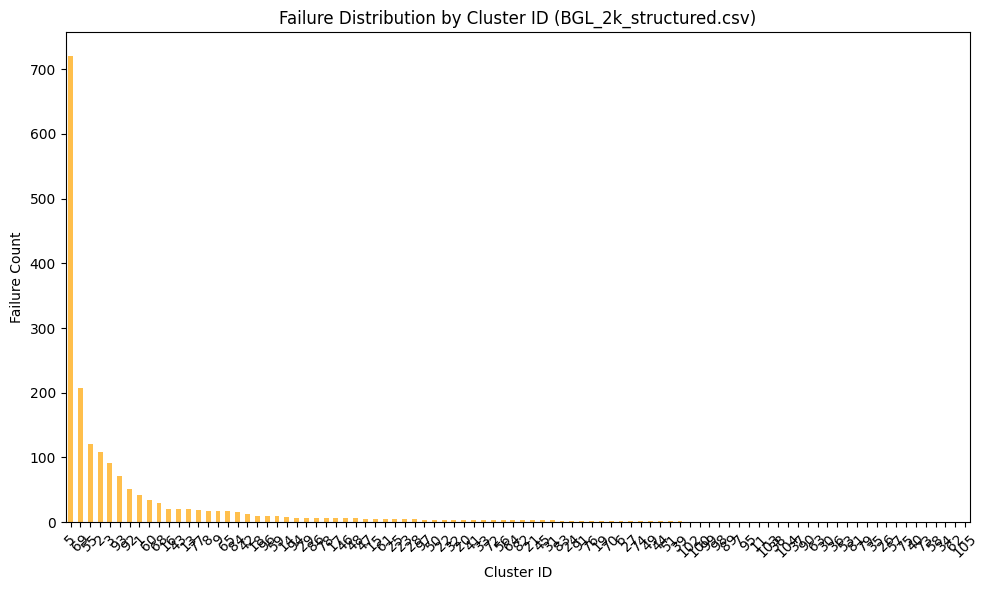


Failures over time:
Date
2005-06-03     8
2005-06-04     1
2005-06-05    45
2005-06-06    15
2005-06-07    16
              ..
2005-12-21     1
2005-12-25     1
2005-12-26     8
2005-12-27     1
2006-01-03     1
Length: 161, dtype: int64


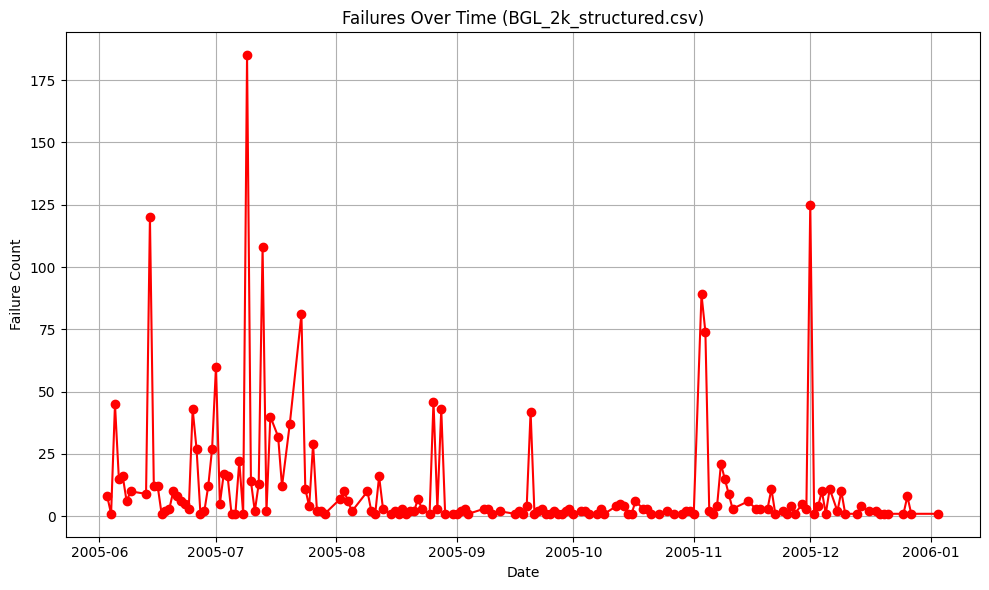


Statistics of time between failures (seconds):
count      1856.000000
mean       9945.592134
std       37290.652713
min           0.000000
25%          18.000000
50%          56.000000
75%         551.250000
max      625691.000000
Name: Timestamp, dtype: float64


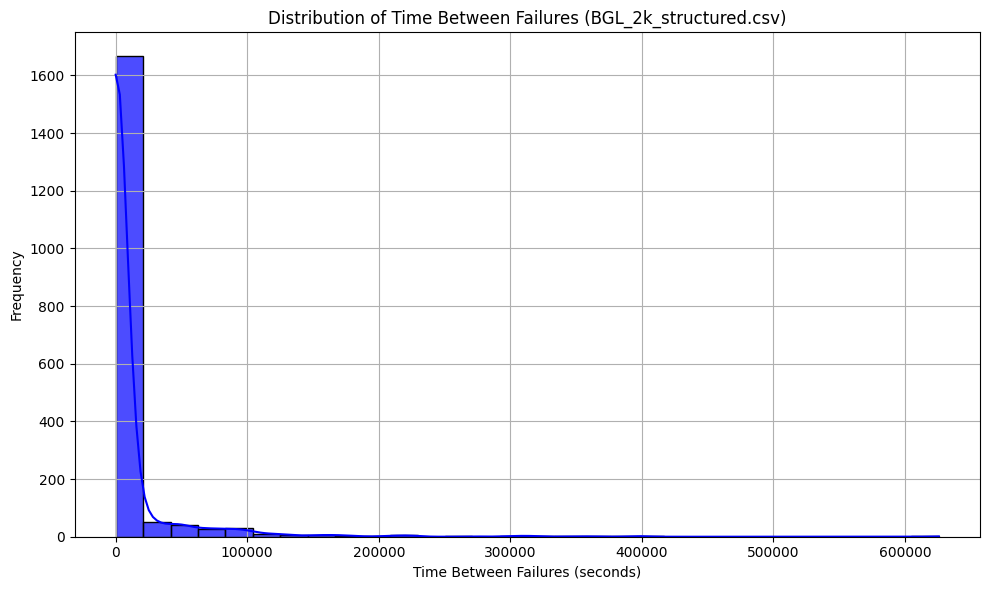

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the directory and file names
log_files = ["BGL_results/BGL_2k_structured.csv"]

# Iterate through the log files
for log_file in log_files:
    if not os.path.exists(log_file):
        print(f"File not found: {log_file}")
        continue
    
    print(f"\nProcessing file: {log_file}")
    
    # Load the structured log data
    df = pd.read_csv(log_file)
    
    # Convert Timestamp to datetime for easier handling
    try:
        if df['Timestamp'].dtype in ['int64', 'float64']:
            # If the Timestamp is in Unix format
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        else:
            # If the Timestamp is a string, attempt to parse it
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f', errors='coerce')
        
        # Check for unparsed Timestamps
        if df['Timestamp'].isna().any():
            raise ValueError("Some timestamps could not be parsed. Check the format of your input data.")
    except Exception as e:
        print(f"Error processing Timestamps in file {log_file}: {e}")
        continue
    
    # Replace Label with numeric values (1 for Anomaly, 0 for Normal)
    df['Label'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)
    
    # Total logs and failures
    total_logs = len(df)
    total_failures = df['Label'].sum()
    failure_percentage = (total_failures / total_logs) * 100
    
    print(f"Total logs: {total_logs}")
    print(f"Total failures: {total_failures}")
    print(f"Failure percentage: {failure_percentage:.2f}%")
    
    # Failure distribution by Cluster ID (log key)
    failure_by_cluster = df[df['Label'] == 1]['Cluster ID'].value_counts()
    print("\nFailures by Cluster ID:")
    print(failure_by_cluster)
    
    # Plot: Failure distribution by Cluster ID
    plt.figure(figsize=(10, 6))
    failure_by_cluster.plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Failure Distribution by Cluster ID ({os.path.basename(log_file)})')
    plt.xlabel('Cluster ID')
    plt.ylabel('Failure Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Failure distribution over time
    df['Date'] = df['Timestamp'].dt.date
    failures_over_time = df[df['Label'] == 1].groupby('Date').size()
    
    print("\nFailures over time:")
    print(failures_over_time)
    
    # Plot: Failures over time
    plt.figure(figsize=(10, 6))
    failures_over_time.plot(kind='line', marker='o', color='red')
    plt.title(f'Failures Over Time ({os.path.basename(log_file)})')
    plt.xlabel('Date')
    plt.ylabel('Failure Count')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Duration between failures
    failure_timestamps = df[df['Label'] == 1]['Timestamp']
    failure_deltas = failure_timestamps.diff().dt.total_seconds().dropna()
    print("\nStatistics of time between failures (seconds):")
    print(failure_deltas.describe())
    
    # Plot: Distribution of time between failures
    plt.figure(figsize=(10, 6))
    sns.histplot(failure_deltas, kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of Time Between Failures ({os.path.basename(log_file)})')
    plt.xlabel('Time Between Failures (seconds)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [24]:
import pandas as pd

def split_slidingwindowfile(input_file, train_file, valid_file, test_file, train_ratio=0.6, valid_ratio=0.2):
    """
    Splits a CSV file into train, validation, and test sets based on the given ratios,
    ensuring the column names are retained.

    Parameters:
    input_file (str): Path to the input CSV file.
    train_file (str): Path to the output train CSV file.
    valid_file (str): Path to the output validation CSV file.
    test_file (str): Path to the output test CSV file.
    train_ratio (float): Ratio of the train set size to the total size (default is 0.6).
    valid_ratio (float): Ratio of the validation set size to the total size (default is 0.2).
    """
    # Read the input CSV file
    data = pd.read_csv(input_file)

    # Shuffle the data to ensure randomness
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate split indices
    train_split_index = int(len(data) * train_ratio)
    valid_split_index = int(len(data) * (train_ratio + valid_ratio))

    # Split the data into train, validation, and test sets
    train_data = data[:train_split_index]
    valid_data = data[train_split_index:valid_split_index]
    test_data = data[valid_split_index:]

    # Write the datasets to CSV files
    train_data.to_csv(train_file, index=False)
    valid_data.to_csv(valid_file, index=False)
    test_data.to_csv(test_file, index=False)

    print(f"Split completed: \n {len(train_data)} rows in {train_file} \n {len(valid_data)} rows in {valid_file} \n {len(test_data)} rows in {test_file}")




In [25]:
split_slidingwindowfile(input_file='BGL_results/BGL_2k_sliding_window.csv', 
              train_file='BGL_results/BGL_2k_train_sliding_window.csv', 
              valid_file='BGL_results/BGL_2k_valid_sliding_window.csv', 
              test_file='BGL_results/BGL_2k_test_sliding_window.csv')

Split completed: 
 5015 rows in BGL_results/BGL_2k_train_sliding_window.csv 
 1672 rows in BGL_results/BGL_2k_valid_sliding_window.csv 
 1672 rows in BGL_results/BGL_2k_test_sliding_window.csv
